# Two approaches in dealing with uncertainty
A Bayesian and Frequentist approach to prediction uncertainty. In both cases, I want to define both aleatoric and epistemic uncertainty.

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error

from functools import partial
from scipy import stats, interpolate
from src.data import generate_dataset

%load_ext autoreload
%autoreload 2

In [13]:
from src.evaluate import crps

In [14]:
crps()

# Generating data

In [2]:
np.random.seed(42)
x, x_test, y, y_test = generate_dataset(n=500, test_size=.2)

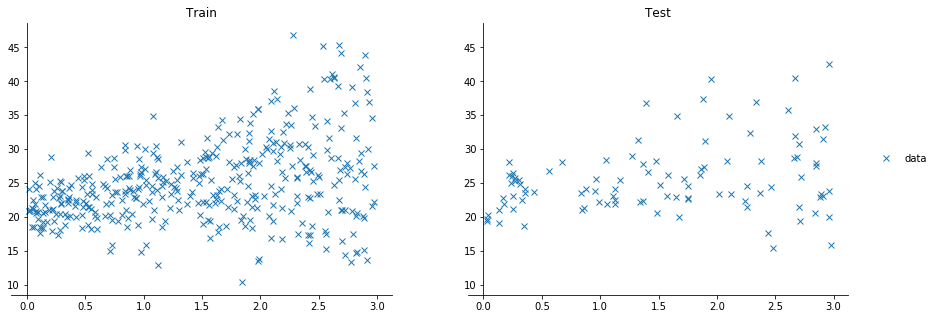

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0].xaxis.set_ticks_position('bottom')
axes[0].yaxis.set_ticks_position('left')
axes[0].spines['left'].set_position(('data', 0))
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1].xaxis.set_ticks_position('bottom')
axes[1].yaxis.set_ticks_position('left')
axes[1].spines['left'].set_position(('data', 0))
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Scaling the data

In [4]:
ssx = MinMaxScaler()
x = ssx.fit_transform(x)
x_test = ssx.transform(x_test)

ssy = MinMaxScaler()
y = ssy.fit_transform(y)
y_test = ssy.transform(y_test)

## The Bayesian approach

**Increasing variance**:

$\sigma_{scale} \sim Normal(0, 10)$

$\sigma_{bias} \sim HalfNormal(10)$

$\sigma = \sigma_{bias} + \sigma_{scale} * x$

**Priors**:

$\alpha \sim Normal(0, 10)$

$\beta \sim Normal(0, 10)$

Linear Regression: $\mu = \alpha + \beta x$

**Likelihood**: 

$y \sim Normal(\mu, \sigma)$

As you can see on the plot, the variance increases when x increases. Therefore I model the variance as a softplus method.

## Modelling in PyMC3
Modelling a linear regression with increasing variance. 

In [85]:
def blr_model():
    with pm.Model() as m:
        alpha = pm.Normal('alpha', 0, 10)
        beta = pm.Normal('beta', 0, 10)
        mu = pm.Deterministic('mu', alpha + beta * x)
        sd_scale = pm.Normal('sd_scale', mu=0, sd=10)
        sd_bias = pm.HalfNormal('sd_bias', sd=10) + 1e-5
        sd = pm.Deterministic('sigma', sd_bias + mu * sd_scale)
        obs = pm.Normal('obs', mu, sd=sd, observed=y)
        return m
        
with blr_model():
    trace = pm.sample(1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_bias, sd_scale, beta, alpha]
Sampling 4 chains:  81%|████████  | 4870/6000 [00:13<00:03, 366.09draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


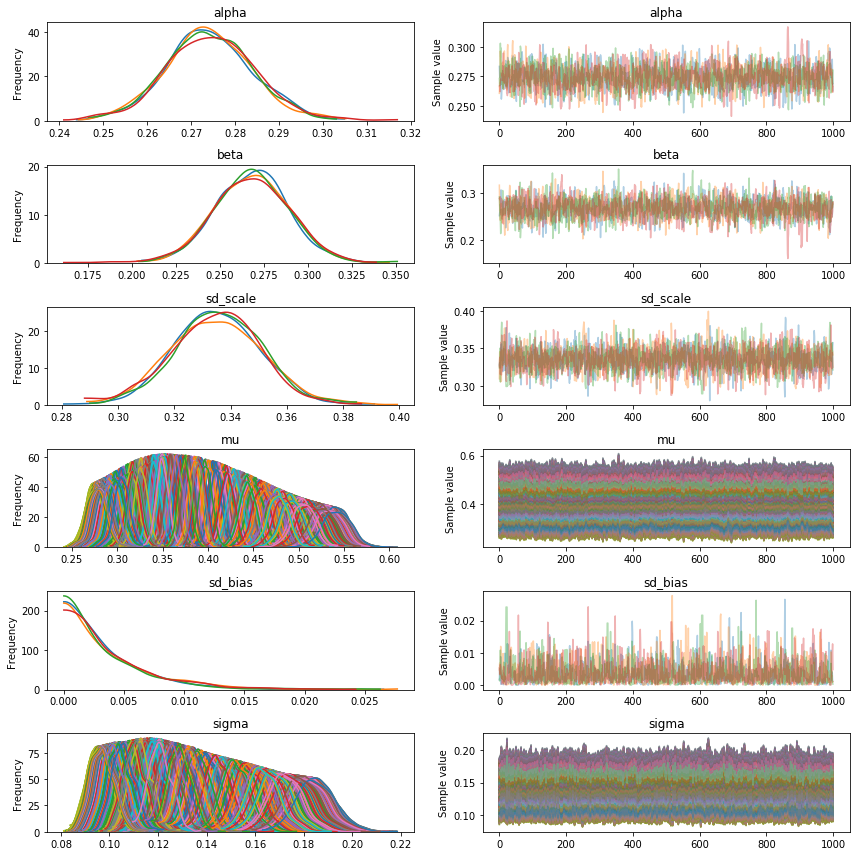

In [6]:
pm.traceplot(trace);

In [33]:
fname = '../models/BLR.trace'
pm.save_trace(trace, directory='../models/BLR.trace')

'../models/BLR.trace'

In [83]:
with blr_model():
    trace = pm.load_trace(fname)

NameError: name 'blr_model' is not defined

In [35]:
with blr_model():
    posterior = pm.sample_posterior_predictive(trace)
    
posterior['obs'].shape

100%|██████████| 4000/4000 [00:02<00:00, 1558.88it/s]


(4000, 400, 1)

In [36]:
np.save('../data/blr_posterior_samples', posterior['obs'])
posterior_obs = np.load('../data/blr_posterior_samples.npy')

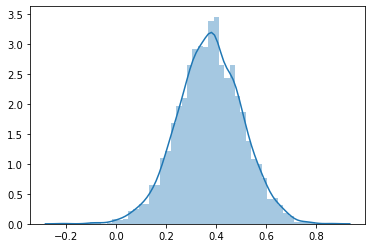

In [66]:
x_i = 0
sns.distplot(posterior_obs[:, x_i, :], bins=50);

## Postprocessing
Sort and calculate credible intervals (2$ * \sigma$) for visualization

In [64]:
sorting_mask = np.argsort(x, axis=0).flatten()
x_ = x[sorting_mask]
mu = (trace['alpha'] + trace['beta'] * x_)
sigma = np.transpose(np.squeeze(trace['sigma'], axis=-1))[sorting_mask, ...]
quantile_preds = np.array([
    mu - 2 * sigma, 
    mu - 1 * sigma,
    mu, 
    mu + 1 * sigma, 
    mu + 2 * sigma
])

## Plotting median and credible interval (2$*\sigma$)

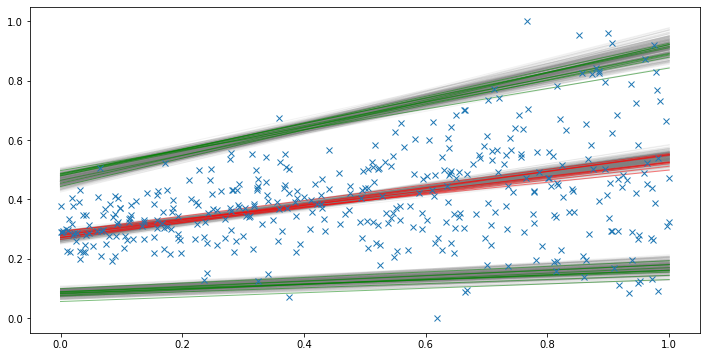

In [45]:
plt.figure(figsize=(12, 6))
n = 300
n_c = 10

plt.plot(x_, mu[..., :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, quantile_preds[0, :, :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, quantile_preds[-1, :, :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, mu[..., n:n+n_c], alpha=.5, lw=1, c='red')
plt.plot(x_, quantile_preds[0][:, n:n+n_c], alpha=.5, lw=1, c='green')
plt.plot(x_, quantile_preds[-1][:, n:n+n_c], alpha=.5, lw=1, c='green')
plt.plot(x, y, 'x');

## Plotting

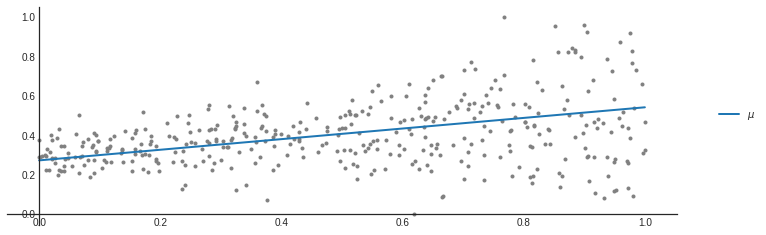

In [68]:
plt.style.use('seaborn-white')
plt.figure(figsize=(12, 4))
n = 30
n_c = 10

mean_mu_s = mu[..., np.random.randint(0, mu.shape[-1], 30)]
mean_mu = np.mean(mu[..., :n], axis=-1)
mean_lo_s = quantile_preds[0][:, :n]
mean_hi_s = quantile_preds[-1][:, :n]
mean_lo = np.mean(quantile_preds[0][:, :n], axis=-1)
mean_hi = np.mean(quantile_preds[-1][:, :n], axis=-1)

# plt.plot(x_, mean_hi, alpha=.5, lw=.7, color='tab:grey', label='$\mu +/- 2\sigma$')
# plt.plot(x_, mean_lo_s, alpha=.5, lw=.7, color='tab:grey')
# plt.plot(x_, mean_hi_s, alpha=.5, lw=.7, color='tab:grey')
# plt.plot(x_, mean_mu, alpha=.7, lw=.7, color='tab:blue', label='$\mu +/- 2\sigma$')
plt.plot(x_, mean_mu, alpha=1, lw=2, color='tab:blue', label='$\mu$')
# plt.plot(x_, mean_mu_s, alpha=.7, lw=.7, color='tab:blue')
# plt.plot(x_, mean_mu[..., 1], alpha=.7, lw=.7, color='tab:blue', label='$\mu$')
# plt.fill_between(x_.flatten(), mean_lo, mean_hi, alpha=.1, color='grey')#, label='$\mu +/- 2\sigma$')

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.scatter(x, y, marker='.', c='grey')
# plt.savefig('../figures/generated_data.png', dpi=300);
plt.savefig('../figures/aleatoric_and_epistemic_uncertainty.png', dpi=300, bbox_inches = 'tight');

## Quantile regression neural network, using MCDropout (in PyTorch)

In [97]:
class MC_Dropout_Layer(nn.Module):
    """ https://github.com/JavierAntoran/Bayesian-Neural-Networks/blob/master/notebooks/regression/mc_dropout_homo.ipynb """
    def __init__(self, input_dim, output_dim, dropout_prob):
        super(MC_Dropout_Layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_prob = dropout_prob
        
        self.weights = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.biases = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        
    def forward(self, x):
        dropout_mask = torch.bernoulli((1 - self.dropout_prob)*torch.ones(self.weights.shape))
        return torch.mm(x, self.weights*dropout_mask) + self.biases

In [117]:
class Dropout_on_dim(torch.nn.modules.dropout._DropoutNd):
    """ Dropout that masks the (hidden) features equally over a batch """
    def __init__(self, p, dim=1, **kwargs):
        super().__init__(p, **kwargs)
        self.dropout_dim = dim
        self.multiplier_ = 1.0 / (1.0-self.p)  # normalize for dropout rate
        
    def forward(self, X):
        mask = torch.bernoulli(
                X.new(X.size(self.dropout_dim)).fill_(1-self.p)
        )
        return X * mask * self.multiplier_
    
class DeepQuantileRegression(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.hidden_size = params['hidden_size']
        self.quantiles = params['quantiles']
        self.model_ = nn.Sequential(
            nn.Linear(params['input_size'], params['hidden_size']),
#             nn.ReLU(),  # when you want to model non-linearities
            Dropout_on_dim(params['dropout_p'], dim=params['dropout_dim']),
#             MC_Dropout_Layer(params['hidden_size'], params['hidden_size'], params['dropout_p']),
            nn.Linear(params['hidden_size'], len(params['quantiles']))
        )
        self.optim_ = torch.optim.Adam(
            self.model_.parameters(), 
            lr=params['lr'], 
            weight_decay=params['weight_decay']
        )
    
    def forward(self, X):
        return self.model_(X)
    
    def mc_predict(self, X, samples=4000):
        with torch.no_grad():
            self.model_.train()
            preds = np.array([self.model_(x_train).numpy().T for _ in range(samples)])
        # To return shape: batch_size, n_quantiles, samples
        return np.swapaxes(preds, 0, -1)
    
    def save(self, path, fname):
        torch.save({
            "model_state_dict": self.model_.state_dict(),
            "optim_state_dict": self.optim_.state_dict(),
        }, os.path.join(path, fname))
    
    def load(self, path, fname):
        checkpoint = torch.load(os.path.join(path, fname))
        self.model_.load_state_dict(checkpoint['model_state_dict'])
        self.optim_.load_state_dict(checkpoint['optim_state_dict'])
        return self

        
def QuantileLoss(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0), f'preds.size:{preds.shape} target.size:{quantiles.shape}'
    assert preds.size(1) == quantiles.shape[0], f'preds.size:{preds.shape} quantiles.shape:{quantiles.shape}'

    def _tilted_loss(q, e):
        return torch.max((q-1) * e, q * e).unsqueeze(1)

    err = target - preds
    losses = [_tilted_loss(q, err[:, i])  # calculate per quantile
              for i, q in enumerate(quantiles)]

    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss    

    
def create_quantiles(n, min_q=0.01, max_q=0.99):
    """ Create array of quantiles, given desired number of quantiles. """
    n -= 2  # because we add the lowest and highest quantiles manually
    n_equally_spaced = np.linspace(1 / (n + 1), 1 - 1 / (n + 1), n)
    quantiles = np.concatenate([np.array([min_q]), 
                                n_equally_spaced, 
                                np.array([max_q])])
    return quantiles

    
def get_quantile_pred(q, used_quantiles, preds):
    interp_cdf = interpolate.interp1d(used_quantiles, preds, fill_value='extrapolate')
    return interp_cdf(q)

## Setting up
- model, model config
- data loader/generator

In [102]:
# QUANTILES = np.array([0.025, 0.16, 0.5, 0.84, 0.975])  # -2std, -1std, median, 1std, 2std
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)
print(f"Used quantiles: {QUANTILES}")
params = {
    'input_size': 1,
    'hidden_size': 128,
    'dropout_p': 0.2,
    'dropout_dim': 1,
    'quantiles': QUANTILES,
    'batch_size': 16,
    'epochs': 2001,
    'lr': 1e-4,
    'weight_decay': 1e-6,
}
model = DeepQuantileRegression(params)
criterion = partial(QuantileLoss, quantiles=QUANTILES)

train_ds = TensorDataset(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
train_dl = DataLoader(train_ds, params['batch_size'], shuffle=True)

Used quantiles: [0.01 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.99]


## Training the model

In [103]:
x_train, y_train = train_dl.dataset.tensors
x_val, y_val = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [143]:
for epoch in range(params['epochs']):
    for x_batch, y_batch in train_dl:
        model.train()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        model.optim_.step()
        model.optim_.zero_grad()
    
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_loss = criterion(model(x_train), y_train)
            val_loss = criterion(model(x_val), y_val)
        print(f"Epoch: {epoch} \t Train loss:{train_loss:.5f} \t Val loss: {val_loss:.5f}")

Epoch: 0 	 Train loss:0.40527 	 Val loss: 0.37712
Epoch: 100 	 Train loss:0.40499 	 Val loss: 0.38639
Epoch: 200 	 Train loss:0.39977 	 Val loss: 0.38182
Epoch: 300 	 Train loss:0.39966 	 Val loss: 0.37664
Epoch: 400 	 Train loss:0.40039 	 Val loss: 0.38054
Epoch: 500 	 Train loss:0.39942 	 Val loss: 0.38501
Epoch: 600 	 Train loss:0.40098 	 Val loss: 0.38655
Epoch: 700 	 Train loss:0.39960 	 Val loss: 0.39790
Epoch: 800 	 Train loss:0.40106 	 Val loss: 0.38126
Epoch: 900 	 Train loss:0.39993 	 Val loss: 0.37198
Epoch: 1000 	 Train loss:0.39993 	 Val loss: 0.37777
Epoch: 1100 	 Train loss:0.40014 	 Val loss: 0.37694
Epoch: 1200 	 Train loss:0.40900 	 Val loss: 0.37634
Epoch: 1300 	 Train loss:0.40051 	 Val loss: 0.39363
Epoch: 1400 	 Train loss:0.40012 	 Val loss: 0.37858
Epoch: 1500 	 Train loss:0.40033 	 Val loss: 0.37707
Epoch: 1600 	 Train loss:0.39990 	 Val loss: 0.38025
Epoch: 1700 	 Train loss:0.40060 	 Val loss: 0.37431
Epoch: 1800 	 Train loss:0.40000 	 Val loss: 0.37785
Epoch

## Saving model state

In [130]:
model.save(path='../models/', fname='deep_quantile_regression.pth')

In [131]:
model = DeepQuantileRegression(params)
model.load(path='../models/', fname='deep_quantile_regression.pth')

DeepQuantileRegression(
  (model_): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Dropout_on_dim(p=0.2, inplace=False)
    (2): Linear(in_features=128, out_features=11, bias=True)
  )
)

## Check if custom dropout layer works as intended

In [144]:
with torch.no_grad():
    model.train()
    x_val_test = torch.zeros(x_val.shape)
    preds_test = np.array([model(x_val_test).numpy() for _ in range(4000)])
    
assert np.array_equal(preds_test[:, 0], preds_test[:, 1]) == True  # every row in batch is masked equally
assert np.array_equal(preds_test[0, :], preds_test[1, :]) == False  # every column (hidden feature) is masked randomly per batch

## Predict

In [145]:
with torch.no_grad():
    model.train()
#     qr_preds = np.array([model(x_val).numpy() for _ in range(4000)])
    qr_preds = np.array([model(x_train).numpy() for _ in range(4000)])

In [146]:
qr_preds.shape

(4000, 400, 11)

## Some postprocessing

In [147]:
sorted_index = x_train.argsort(axis=0).flatten()
x_, y_hat = x_train[sorted_index].numpy(), qr_preds[:, sorted_index, :]
x_.shape, y_hat.shape

((400, 1), (4000, 400, 11))

## Plotting median and credible interval (2$*\sigma$)

In [148]:
q_975 = np.array([
    get_quantile_pred(q=.975, used_quantiles=QUANTILES, preds=y_hat[i, ...]) 
    for i in range(y_hat.shape[0])
]).T

q_025 = np.array([
    get_quantile_pred(q=.025, used_quantiles=QUANTILES, preds=y_hat[i, ...]) 
    for i in range(y_hat.shape[0])
]).T

median_i = int(QUANTILES.shape[-1]/2)
q_50 = y_hat[..., median_i].T

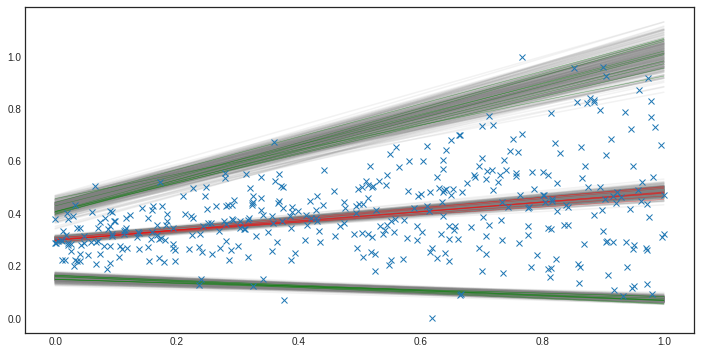

In [149]:
plt.figure(figsize=(12, 6))
n = 300
n_c = 10

plt.plot(x_, q_025[:, :n], c='grey', alpha=.1)
plt.plot(x_, q_50[:, :n], c='grey', alpha=.1)
plt.plot(x_, q_975[:, :n], c='grey', alpha=.1)
plt.plot(x_, q_025[:, n:n+n_c], c='green', alpha=.5, lw=.5)
plt.plot(x_, q_50[:, n:n+n_c], c='red', alpha=.5, lw=.5)
plt.plot(x_, q_975[:, n:n+n_c], c='green', alpha=.5, lw=.5)

plt.plot(x, y, 'x')
plt.show();

In [150]:
q_975.shape

(400, 4000)

In [151]:
q_all = np.array([
    np.array([get_quantile_pred(q=q_, used_quantiles=QUANTILES, preds=y_hat[i, ...]) 
              for i in range(y_hat.shape[0])]).T
    for q_ in QUANTILES
])
q_all.shape

(11, 400, 4000)

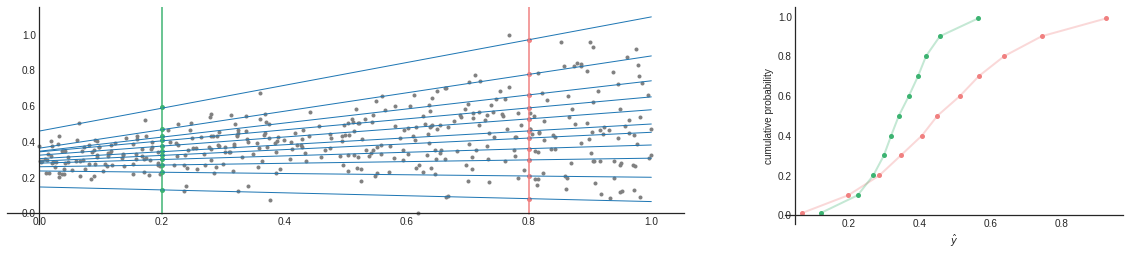

In [153]:
plt.style.use('seaborn-white')

fig, axes = plt.subplots(1, 2, figsize=(20,4), gridspec_kw={'width_ratios': [2, 1]})

axes[0].xaxis.set_ticks_position('bottom')
axes[0].yaxis.set_ticks_position('left')
axes[0].spines['left'].set_position(('data', 0))
axes[0].spines['bottom'].set_position(('data', 0))
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

axes[1].xaxis.set_ticks_position('bottom')
axes[1].yaxis.set_ticks_position('left')
axes[1].spines['left'].set_position(('data', 0.05))
axes[1].spines['bottom'].set_position(('data', 0))
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlabel('$\\hat{y}$')
axes[1].set_ylabel('cumulative probability')


q_means = np.mean(q_all, axis=-1)
q_means = q_all[..., 0]

for i, q_mean in enumerate(q_means):
    axes[0].plot(x_, q_mean, lw=1, alpha=1, color='tab:blue')
axes[0].axvline(.8, 0.05, 1, c='lightcoral')
axes[0].axvline(.2, 0.05, 1, c='mediumseagreen')
axes[0].scatter(x, y, marker='.', c='grey')

# axes[0].legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
axes[1].scatter(np.mean(q_all[:, 315, :], axis=-1).reshape(-1,1), QUANTILES.reshape(-1,1), marker='.', color='lightcoral', lw=2)
axes[1].plot(np.mean(q_all[:, 315, :], axis=-1).reshape(-1,1), QUANTILES.reshape(-1,1), alpha=0.3, color='lightcoral', lw=2)

axes[1].scatter(np.mean(q_all[:, 90, :], axis=-1).reshape(-1,1), QUANTILES.reshape(-1,1), marker='.', color='mediumseagreen', lw=2)
axes[1].plot(np.mean(q_all[:, 90, :], axis=-1).reshape(-1,1), QUANTILES.reshape(-1,1), alpha=0.3, color='mediumseagreen', lw=2)

axes[0].scatter(np.repeat([.2], 11), q_means[:, 90], marker='.', color='mediumseagreen', lw=2)
axes[0].scatter(np.repeat([.8], 11), q_means[:, 315], marker='.', color='lightcoral', lw=2)

plt.savefig('../figures/21_quantiles.png', dpi=300, bbox_inches = 'tight');

In [215]:
QUANTILES.reshape(-1,1).shape

(11, 1)

In [217]:
samps = list(range(1,31)) + [50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 800, 1000, 1200, 1500, 2000, 2500, 3000, 3500, 4000]
plt.style.use('seaborn-white')

random_i = np.random.randint(0,len(x_), 1)
input_feature_x = x_[random_i][0,0]
print(f"Generating posterior for input:{input_feature_x:.5f}")
samples = np.array([])

for s in range(qr_preds.shape[0]):
    random_q = stats.uniform.rvs()
    interp_y = get_quantile_pred(q=random_q, 
                                 used_quantiles=QUANTILES, 
                                 preds=qr_preds[s, i, :])
    samples = np.append(samples, interp_y)
    if s in samps:
        fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True)
        axes[0].xaxis.set_ticks_position('bottom')
        axes[0].yaxis.set_ticks_position('left')
        axes[0].spines['left'].set_position(('data', 0))
        axes[0].spines['bottom'].set_position(('data', 0))
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['right'].set_visible(False)
        axes[0].axhline(random_q, 0, interp_y, c='lightcoral')
        axes[0].axvline(interp_y, 0, random_q, c='lightcoral')
        axes[0].set_xlim(0,1)
        axes[0].set_ylim(0,1)
        axes[0].set_xlabel('$\\hat{y}$')
        axes[0].set_ylabel('cumulative probability')
        axes[0].scatter(qr_preds[s, i, :], QUANTILES.reshape(-1,1), marker='.', color='tab:blue', lw=2)
        axes[0].plot(qr_preds[s, i, :], QUANTILES.reshape(-1,1), alpha=0.3, color='tab:blue', lw=2)
        axes[0].set_title("Sample approximate CDF")

        sns.distplot(samples, ax=axes[1], norm_hist=True)
        axes[1].xaxis.set_ticks_position('bottom')
        axes[1].yaxis.set_ticks_position('left')
        axes[1].spines['left'].set_position(('data', 0.0))
        axes[1].spines['bottom'].set_position(('data', 0))
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)
        axes[1].set_xlim(0,1)
        axes[1].set_xlabel('$\\hat{y}$')
        axes[1].set_ylabel('frequency')
        axes[1].set_title("Approximate posterior predictive distribution")

        plt.suptitle(f"Sampled: {s} time(s)  -  input feature: {input_feature_x:.5f}")
        plt.savefig(f'../figures/animation/sample_{str(s).zfill(4)}.png', dpi=100, bbox_inches = 'tight');
        plt.clf();
    else:
        continue

Generating posterior for input:0.16686


/home/yuri/.local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

In [218]:
# ! convert -delay 25 -loop 0 plots/animation/*.png animatedGIF.gif

In [154]:
sample_mu = np.mean(samples)
sample_lo = np.quantile(samples, q=.025)
sample_hi = np.quantile(samples, q=.975)

ax = plt.gca()
sns.distplot(samples, ax=ax, norm_hist=True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0,1)
ax.set_xlabel('$\\hat{y}$')
ax.set_ylabel('frequency')
ax.set_title("Approximate posterior predictive distribution")
ax.axvline(sample_lo, color='lightcoral')
ax.text(0.07, 3, "$q_{0.025}$", color='lightcoral')
ax.axvline(sample_hi, color='lightcoral')
ax.text(sample_hi, 3, "$q_{0.975}$", color='lightcoral')
ax.axvline(sample_mu, color='mediumseagreen')
ax.text(.3, 5, "$\mu$", color='mediumseagreen')

plt.title(f"Sampled: {s+1} time(s)  -  input feature: {input_feature_x:.5f}");
plt.savefig('../figures/app_sample.png', dpi=300, bbox_inches='tight')
print(f"My best gues for input {input_feature_x:.5f} is {sample_mu:.5f}")
print(f"And I am 95% sure, the true value is between {sample_lo:.5f} and {sample_hi:.5f}")

NameError: name 'samples' is not defined

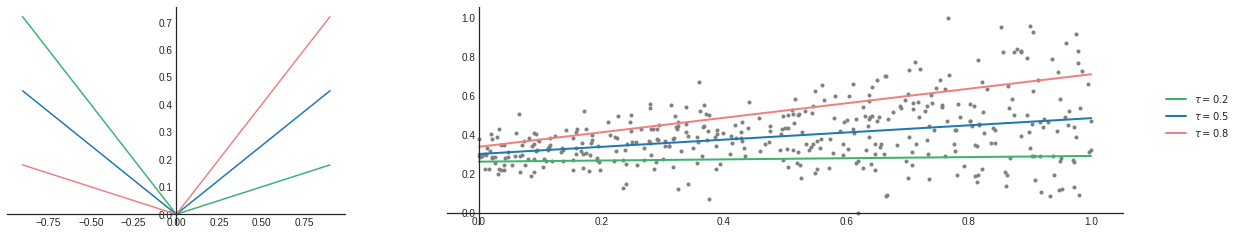

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(20,4), gridspec_kw={'width_ratios': [1, 2]})
axes[1].scatter(x, y, marker='.', c='grey')
    
for plot_q, c in [(.2, 'mediumseagreen'), (.5, 'tab:blue'), (.8, 'lightcoral')]:

    qx = np.array([
        get_quantile_pred(q=plot_q, used_quantiles=QUANTILES, preds=y_hat[i, ...]) 
        for i in range(y_hat.shape[0])
    ]).T

    def _tilted_loss(q, e):
        return max((q-1.) * e, q * e)
    X = np.arange(-1+.1, 1, .1)


    axes[0].plot(X, [_tilted_loss(plot_q, x) for x in X], label=f"$\\tau={plot_q}$", color=c)
    axes[1].plot(x_, np.mean(qx, axis=-1), lw=2, label=f"$\\tau={plot_q}$", color=c)
    axes[1].legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
    
    for ax in axes:
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data', 0))
        ax.spines['bottom'].set_position(('data', 0))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.savefig('../figures/quantile_loss_vs_regression.png', dpi=300, bbox_inches = 'tight');

## Comparing the outcome of the two methods

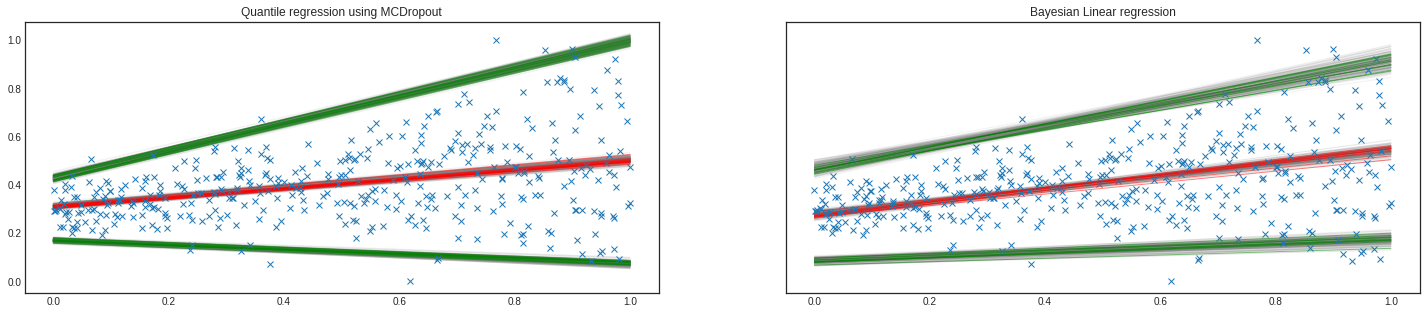

In [223]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25,5))
n = 200
n_c = 10

axes[0].plot(x_, q_025[:, :n], c='grey', alpha=.1)
axes[0].plot(x_, q_50[:, :n], c='grey', alpha=.1)
axes[0].plot(x_, q_975[:, :n], c='grey', alpha=.1)
axes[0].plot(x_, q_025[:, n:n+n_c], c='green', alpha=.5)
axes[0].plot(x_, q_50[:, n:n+n_c], c='red', alpha=.5)
axes[0].plot(x_, q_975[:, n:n+n_c], c='green', alpha=.5)
axes[0].plot(x, y, 'x')
axes[0].set_title('Quantile regression using MCDropout')

axes[1].plot(x_, mu[..., :n], alpha=.1, lw=1, c='grey')
axes[1].plot(x_, quantile_preds[0, :, :n], alpha=.1, lw=1, c='grey')
axes[1].plot(x_, quantile_preds[-1, :, :n], alpha=.1, lw=1, c='grey')
axes[1].plot(x_, mu[..., n:n+n_c], alpha=.5, lw=1, c='red')
axes[1].plot(x_, quantile_preds[0][:, n:n+n_c], alpha=.5, lw=1, c='green')
axes[1].plot(x_, quantile_preds[-1][:, n:n+n_c], alpha=.5, lw=1, c='green')
axes[1].plot(x, y, 'x')
axes[1].set_title('Bayesian Linear regression');

## Averaging
When taking the mean of the samples, the result is quite close...

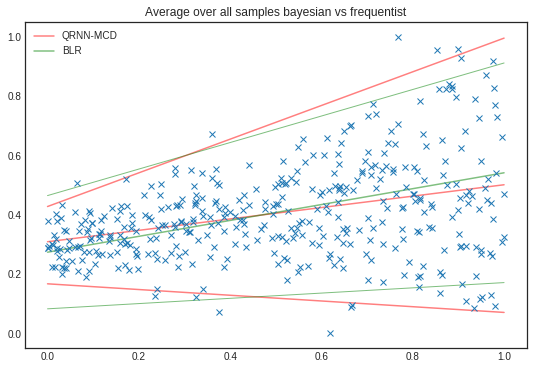

In [224]:
fig = plt.figure(figsize=(9,6))

plt.plot(x_, np.mean(q_025[:, :], axis=-1), c='red', alpha=.5)
plt.plot(x_, np.mean(q_50[:, :], axis=-1), c='red', alpha=.5, label="QRNN-MCD")
plt.plot(x_, np.mean(q_975[:, :], axis=-1), c='red', alpha=.5)

plt.plot(x_, np.mean(mu, axis=-1), alpha=.5, c='green', label="BLR")
plt.plot(x_, np.mean(quantile_preds[0], axis=-1), alpha=.5, lw=1, c='green')
plt.plot(x_, np.mean(quantile_preds[-1], axis=-1), alpha=.5, lw=1, c='green')

plt.plot(x, y, 'x')
plt.title('Average over all samples bayesian vs frequentist')
plt.legend();

## Looking at single predictions

In [225]:
def spread(preds) -> np.array:
    """ Calculates the spread of the predictions per quantile """
    spreads = np.zeros(preds.shape[0])
    avg_factor = 2 * preds.shape[1] * (preds.shape[1] - 1)
    for i in range(preds.shape[0]):
        spreads[i] = (
            np.sum(np.abs(np.subtract.outer(preds[i], preds[i]))) / avg_factor
        )
    return spreads


def distance(y_true, preds) -> np.array:
    """ Calculates the avg distance of the quantile predictions compared to
    the actual """
    return np.mean(np.abs(preds - y_true.reshape(-1, 1)), axis=1)


def rps(y_true: np.array, preds: np.array) -> np.float64:
    """ Function that calculates the RPS by calculating and substracting the
    distance of the distribution compared to the actual value and the spread of
    the distribution.

    Implementation is based on a previous implementation @KLM, in order to
    compare scores of 'old' models and new developped ones. For more info,
    please check: https://bitbucket.devnet.klm.com/projects/OPSM/repos/delay_predictor/browse/delayprediction/metrics.py#106

    Parameters
    ----------
    y_true
        Array containing the actual delays, size = (batch_size x 1)
    preds
        Array containing the predictions of the 21 quantiles,
        size = (batch_size x 21)

    Returns
    -------
    :
        RPS score
    """
    rps_scores = distance(y_true, preds) - spread(preds)
    return np.mean(rps_scores)

In [226]:
from scipy.integrate import simps
from scipy.interpolate import interp1d


def crps(y_true, y_pred, qs):
    def _single_crps(y_true, y_pred, qs):
        mask = np.where(y_pred > y_true, True, False)
        int_cdf = interp1d(y_pred, qs, fill_value='extrapolate')
        int_q = int_cdf(y_true)
        y_left = np.append(y_pred[~mask], y_true)
        y_right = np.append(y_true, y_pred[mask])
        q_left = np.append(QUANTILES[~mask], int_q)
        q_right = np.append(int_q, QUANTILES[mask])
        return simps(q_left, y_left) + simps(1 - q_right, y_right)
        
    crps_ = np.array([_single_crps(y_t, y_p, qs)
                      for y_t, y_p in zip(y_true, y_pred)])
    return np.mean(crps_)

crps(y[sorting_mask], np.mean(qr_preds, axis=0), QUANTILES)

0.17849241872560617

(0, 1)

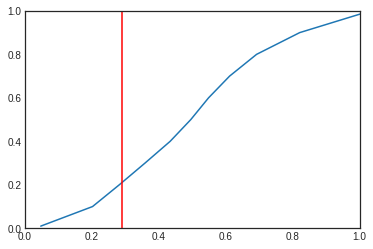

In [227]:
plt.plot(np.mean(qr_preds, axis=0)[np.random.randint(0, len(x))], QUANTILES)
plt.axvline(y[sorting_mask][1], c='r')
plt.xlim(0,1)
plt.ylim(0,1)

In [228]:
rps(y[sorting_mask].reshape(-1,1), np.mean(qr_preds, axis=0))

0.08894573733571183

## Aiming for the true posterior

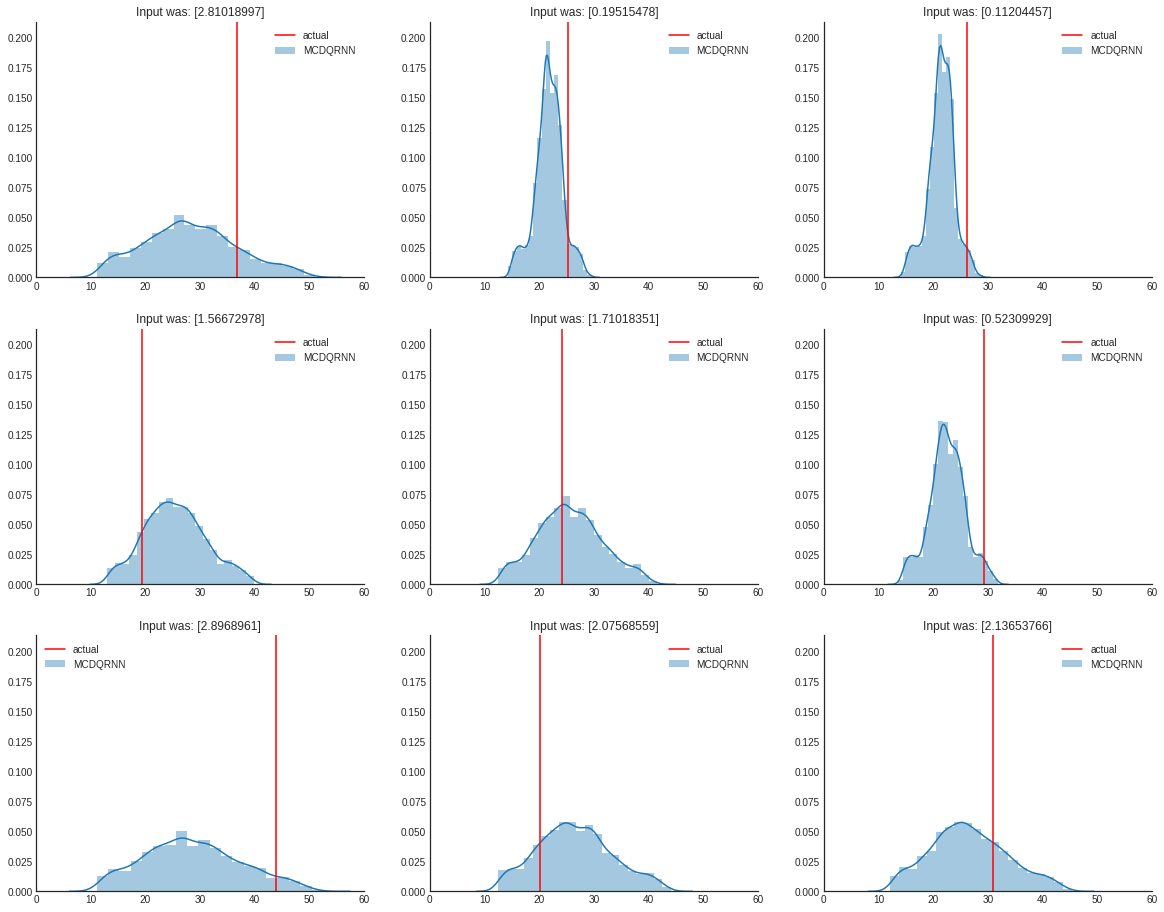

In [156]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
for i, ax in enumerate(axes.flat):
    i = np.random.randint(0, 300)
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    blr_posterior = ssy.inverse_transform(posterior['obs'][:, i, 0].reshape(-1,1))
#     sns.distplot(blr_posterior, bins=50, ax=ax, label='BLR')
    mcd_qrnn_posterior = ssy.inverse_transform(
        np.array([
            get_quantile_pred(q=stats.uniform.rvs(), 
                              used_quantiles=QUANTILES, 
                              preds=qr_preds[s, i, :])
            for s in range(qr_preds.shape[0])
        ]).reshape(-1,1)
    )
    sns.distplot(mcd_qrnn_posterior, bins=20, ax=ax, label='MCDQRNN');
    ax.axvline(ssy.inverse_transform(y)[i], c='r', label='actual')
    ax.set_title(f"Input was: {ssx.inverse_transform(x)[i]}")
    ax.legend()
    ax.set_xlim(0, 60)
# plt.show()
plt.savefig('../figures/matrix_results.png', dpi=300, bbox_inches='tight');

## Comparing RPS scores

In [230]:
mcd_qrnn_posterior = np.array([get_quantile_pred(q=stats.uniform.rvs(), 
                                                 used_quantiles=QUANTILES, 
                                                 preds=qr_preds[s, ...]) 
                               for s in range(qr_preds.shape[0])])
mcd_qrnn_21qs = np.quantile(mcd_qrnn_posterior, QUANTILES, axis=0)
blr_21qs = np.quantile(posterior['obs'][:, :, 0], QUANTILES, axis=0)

In [231]:
print("Comparing RPS (lower is better)")
print("="*31)
print(f"RPS-QRMCDNN:{rps(ssy.inverse_transform(y), ssy.inverse_transform(mcd_qrnn_21qs.T)):.5f}")
print(f"RPS-BLR    :{rps(ssy.inverse_transform(y), ssy.inverse_transform(blr_21qs.T)):.5f}")

Comparing RPS (lower is better)
RPS-QRMCDNN:2.60411
RPS-BLR    :2.67376


In [232]:
mcd_qrnn_posterior.shape

(4000, 400)

In [233]:
print("Comparing MAE of the mean of the posterior (lower is better)")
print("="*60)
mae_b = mean_absolute_error(
    ssy.inverse_transform(y), 
    ssy.inverse_transform(np.median(posterior['obs'][:, :, 0], axis=0).reshape(-1,1))
)
mae_qr = mean_absolute_error(
    ssy.inverse_transform(y), 
    ssy.inverse_transform(np.median(mcd_qrnn_posterior, axis=0).reshape(-1,1))
)
print(f"RPS-QRMCDNN: {mae_qr}")
print(f"RPS-BLR    : {mae_b}")

Comparing MAE of the mean of the posterior (lower is better)
RPS-QRMCDNN: 4.121000463838305
RPS-BLR    : 4.175813807215385


In [234]:
from sklearn.metrics import mean_squared_error

In [235]:
print("Comparing RMSE of the mean of the posterior (lower is better)")
print("="*60)
mae_b = np.sqrt(mean_squared_error(
    ssy.inverse_transform(y), 
    ssy.inverse_transform(np.mean(posterior['obs'][:, :, 0], axis=0).reshape(-1,1))
))
mae_qr = np.sqrt(mean_squared_error(
    ssy.inverse_transform(y), 
    ssy.inverse_transform(np.mean(mcd_qrnn_posterior, axis=0).reshape(-1,1))
))
print(f"RPS-QRMCDNN: {mae_qr}")
print(f"RPS-BLR    : {mae_b}")

Comparing RMSE of the mean of the posterior (lower is better)
RPS-QRMCDNN: 5.542203027789541
RPS-BLR    : 5.593590036281555
